In [82]:
import torch
from torchvision import models, transforms, datasets
from torch import nn, optim
from torch.utils.data import DataLoader


from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm

from utils import  full_loss, tsne_visualization, CIFAR100CoarseUnbalanced, sparse2coarse, CustomViT

In [83]:
transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

trainset = datasets.CIFAR100(root='./data', train=True, download=False, transform=transform)
valset = datasets.CIFAR100(root='./data', train=False, download=False, transform=transform)

unbalanced_trainset = CIFAR100CoarseUnbalanced(trainset)

In [84]:
batch_size = 1024

trainloader = DataLoader(unbalanced_trainset, batch_size = batch_size, shuffle=True, num_workers = 6)
valloader = DataLoader(valset, batch_size = batch_size, shuffle=False, num_workers = 6)

In [85]:
epochs = 15
embed_dim = 256
model = CustomViT(num_classes=20, patch_size=4, num_layers=7, embed_dim=embed_dim, num_heads=4, ff_dim=512)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()

train_loss_history = []
val_loss_history = []
device_id = 1

device = torch.device(f'cuda:{device_id}' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
alpha = 0.25

/home/infres/egardes-21/.local/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
for epoch in range(epochs):
    model.train()
    train_loss = 0
    total_steps = 0
    for i, (images, labels, _) in enumerate(tqdm(trainloader)):
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)
        patches = model.patch_embed(images)
        patches = patches.flatten(2).transpose(1, 2)
        features = model.transformer(patches).mean(dim = 1)
        logits = model.fc(features)
        ce_loss = criterion(logits, labels.long())
        paper_loss = full_loss(features, labels, alpha = alpha)
        loss = ce_loss + 0.1 * paper_loss
        loss.backward()
        optimizer.step()
        total_steps +=1
        train_loss += loss.item()
    
    train_loss_history.append(train_loss / total_steps)    
    tqdm.write(f'Epoch: {epoch}, Loss: {train_loss / total_steps}')

    model.eval()
    with torch.no_grad():
        val_loss = 0
        total_steps
        for i, (images, original_labels) in enumerate(valloader):
            labels = sparse2coarse(original_labels)
            images, labels = images.to(device), torch.tensor(labels).to(device)
            patches = model.patch_embed(images)
            patches = patches.flatten(2).transpose(1, 2)
            features = model.transformer(patches).mean(dim = 1)
            logits = model.fc(features)
            ce_loss = criterion(logits, labels)
            paper_loss = full_loss(features, labels, alpha = alpha)
            loss = 0.5 * ce_loss + 0.5 * paper_loss
            val_loss += loss.item()
            total_steps += 1    
        val_loss_history.append(val_loss / total_steps)
    tqdm.write(f'Epoch: {epoch}, Val Loss: {val_loss / total_steps}')

100%|██████████| 19/19 [00:06<00:00,  3.05it/s]

Epoch: 0, Loss: 5.02697595797087


Epoch: 0, Val Loss: 1.181845919839267


100%|██████████| 19/19 [00:06<00:00,  3.00it/s]

Epoch: 1, Loss: 4.786689708107396


Epoch: 1, Val Loss: 1.1489257072580272


100%|██████████| 19/19 [00:06<00:00,  2.99it/s]

Epoch: 2, Loss: 4.615208148956299


Epoch: 2, Val Loss: 1.1142446090435159


100%|██████████| 19/19 [00:06<00:00,  3.00it/s]

Epoch: 3, Loss: 4.456566308674059


Epoch: 3, Val Loss: 1.0839780445756584


100%|██████████| 19/19 [00:06<00:00,  3.01it/s]

Epoch: 4, Loss: 4.330558312566657


Epoch: 4, Val Loss: 1.0670655513631886


100%|██████████| 19/19 [00:06<00:00,  2.97it/s]

Epoch: 5, Loss: 4.254087686538696


Epoch: 5, Val Loss: 1.0565094947814941


100%|██████████| 19/19 [00:06<00:00,  3.00it/s]

Epoch: 6, Loss: 4.1897412977720565


Epoch: 6, Val Loss: 1.0412527281662514


100%|██████████| 19/19 [00:06<00:00,  2.98it/s]

Epoch: 7, Loss: 4.126983504546316


Epoch: 7, Val Loss: 1.0359728336334229


100%|██████████| 19/19 [00:06<00:00,  2.94it/s]

Epoch: 8, Loss: 4.068585471103066


Epoch: 8, Val Loss: 1.0219452216707428


100%|██████████| 19/19 [00:06<00:00,  2.93it/s]

Epoch: 9, Loss: 4.036080887443141


Epoch: 9, Val Loss: 1.0270365188861716


100%|██████████| 19/19 [00:06<00:00,  2.96it/s]

Epoch: 10, Loss: 4.021986258657355


Epoch: 10, Val Loss: 1.0246748759828765


100%|██████████| 19/19 [00:06<00:00,  2.96it/s]

Epoch: 11, Loss: 3.971275392331575


Epoch: 11, Val Loss: 1.0042979799467942


100%|██████████| 19/19 [00:06<00:00,  2.96it/s]

Epoch: 12, Loss: 3.9081529065182337


Epoch: 12, Val Loss: 1.0101827259721428


100%|██████████| 19/19 [00:06<00:00,  2.96it/s]

Epoch: 13, Loss: 3.8708640776182475


Epoch: 13, Val Loss: 0.9952569583366657


100%|██████████| 19/19 [00:06<00:00,  2.97it/s]

Epoch: 14, Loss: 3.833402570925261


Epoch: 14, Val Loss: 0.9935968579917118


Text(0.5, 1.0, 'Val Loss')

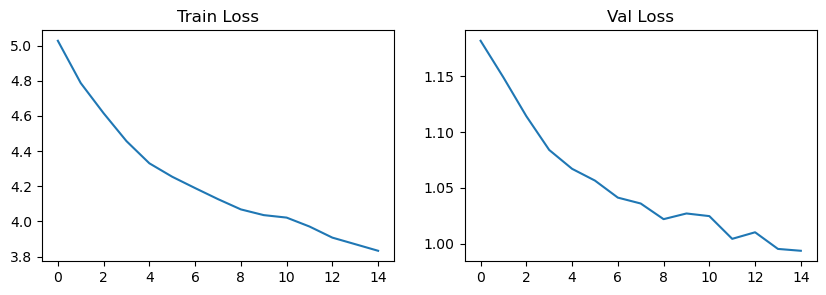

In [87]:
model.eval()
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].plot(train_loss_history)
axes[0].set_title('Train Loss')
axes[1].plot(val_loss_history)
axes[1].set_title('Val Loss')

In [88]:
allowed_strata = [8, 13, 48, 58, 90, 27, 29, 44, 78, 93]  ### corresponding to two classes

batch_size = 256
valloader = DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=4)

embeddings_list = []
labels_list = []
stratum_list = []

model.eval()
with torch.no_grad():
    for i, (images, strata) in enumerate(tqdm(valloader)):
        
        if len(strata) != batch_size:
            continue
        
        label = sparse2coarse(strata)
        images = images.to(device)
        
        features = model(images)

        for j in range(batch_size):
            if strata[j].item() in allowed_strata:
                embeddings_list.append(features[j].cpu().numpy())  
                stratum_list.append(strata[j].item())     
                labels_list.append(label[j])   

embeddings = np.array(embeddings_list)
labels = np.array(labels_list)
stratum = np.array(stratum_list)

100%|██████████| 40/40 [00:01<00:00, 32.45it/s]


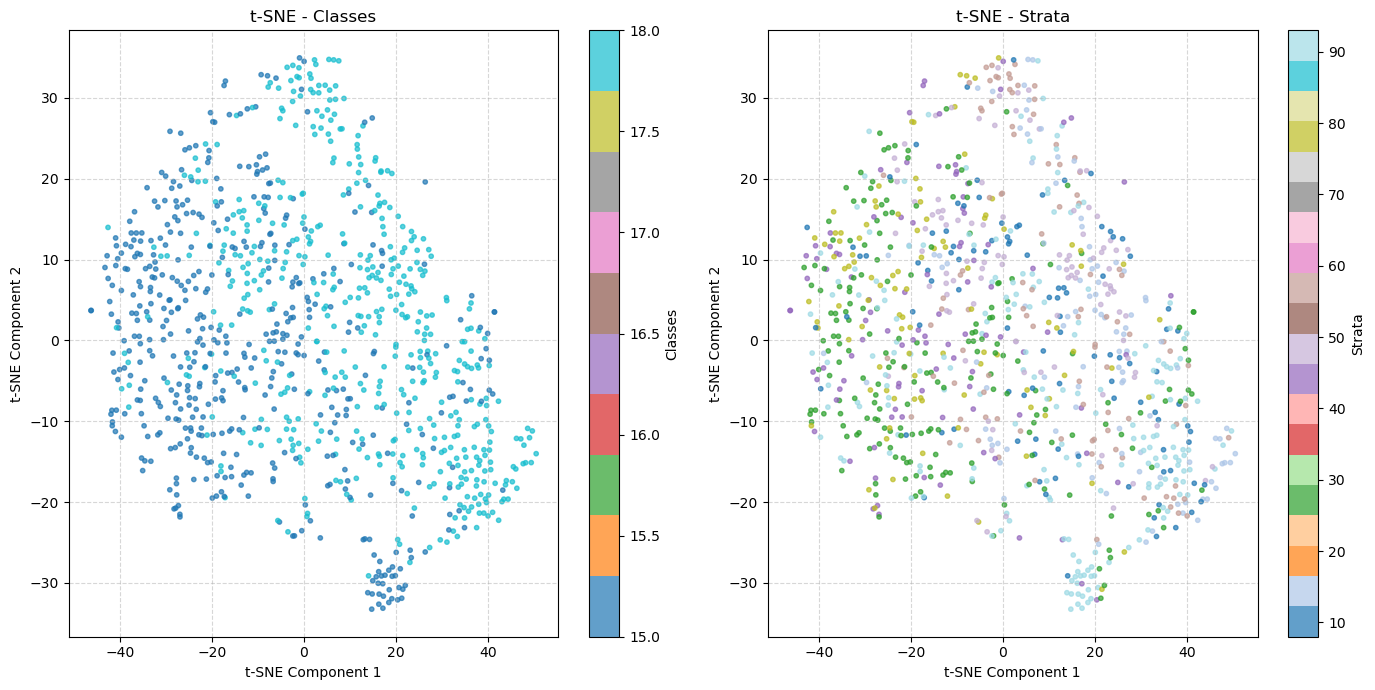

In [89]:
tsne_visualization(embeddings, labels, stratum, title="t-SNE")

In [90]:
#model.fc = nn.Sequential(nn.Linear(embed_dim, 20))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.0003)
model = model.to(device)

for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

train_accuracy = []
val_accuracy = []

epochs = 12

In [91]:
for epoch in range(epochs):
    model.train()
    train_loss = 0
    total_steps = 0
    correct = 0
    total = 0
    for i, (images, labels, _) in enumerate(tqdm(trainloader)):
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()
        total_steps +=1
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_accuracy.append(correct / total)    
    tqdm.write(f'Epoch: {epoch}, Loss: {train_loss / total_steps}, Accuracy: {correct / total}')

    model.eval()
    with torch.no_grad():
        val_loss = 0
        total_steps = 0
        correct = 0
        total = 0
        for i, (images, strata) in enumerate(valloader):
            labels = sparse2coarse(strata)
            images, labels = images.to(device), torch.tensor(labels).to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            total_steps += 1
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        val_accuracy.append(correct / total)
    
    tqdm.write(f'Epoch: {epoch}, Val Loss: {val_loss / total_steps}, Val Accuracy: {correct / total}')

100%|██████████| 19/19 [00:02<00:00,  7.51it/s]

Epoch: 0, Loss: 2.0372499854941117, Accuracy: 0.38252631578947366


Epoch: 0, Val Loss: 2.2557472050189973, Val Accuracy: 0.3056


100%|██████████| 19/19 [00:02<00:00,  7.38it/s]

Epoch: 1, Loss: 2.0155741352784005, Accuracy: 0.39142105263157895


Epoch: 1, Val Loss: 2.233693027496338, Val Accuracy: 0.3093


100%|██████████| 19/19 [00:02<00:00,  7.61it/s]

Epoch: 2, Loss: 1.9987663783525165, Accuracy: 0.39710526315789474


Epoch: 2, Val Loss: 2.2251478314399717, Val Accuracy: 0.3117


100%|██████████| 19/19 [00:02<00:00,  7.56it/s]

Epoch: 3, Loss: 1.9925027144582648, Accuracy: 0.3971578947368421


Epoch: 3, Val Loss: 2.2154979348182677, Val Accuracy: 0.3126


100%|██████████| 19/19 [00:02<00:00,  7.45it/s]

Epoch: 4, Loss: 1.9837188595219661, Accuracy: 0.4006842105263158


Epoch: 4, Val Loss: 2.2194333523511887, Val Accuracy: 0.315


100%|██████████| 19/19 [00:02<00:00,  7.50it/s]

Epoch: 5, Loss: 1.9767941236495972, Accuracy: 0.399


Epoch: 5, Val Loss: 2.2578314781188964, Val Accuracy: 0.3152


100%|██████████| 19/19 [00:02<00:00,  7.45it/s]

Epoch: 6, Loss: 1.9738414664017527, Accuracy: 0.4022631578947368


Epoch: 6, Val Loss: 2.2195598483085632, Val Accuracy: 0.3165


100%|██████████| 19/19 [00:02<00:00,  7.50it/s]

Epoch: 7, Loss: 1.9664497250004818, Accuracy: 0.404


Epoch: 7, Val Loss: 2.215654307603836, Val Accuracy: 0.3137


100%|██████████| 19/19 [00:02<00:00,  7.36it/s]

Epoch: 8, Loss: 1.9725761915508069, Accuracy: 0.40221052631578946


Epoch: 8, Val Loss: 2.2128108978271483, Val Accuracy: 0.3181


100%|██████████| 19/19 [00:02<00:00,  7.51it/s]

Epoch: 9, Loss: 1.9602846095436497, Accuracy: 0.40578947368421053


Epoch: 9, Val Loss: 2.2313007771968842, Val Accuracy: 0.32


100%|██████████| 19/19 [00:02<00:00,  7.48it/s]

Epoch: 10, Loss: 1.9597050578970658, Accuracy: 0.40389473684210525


Epoch: 10, Val Loss: 2.205438905954361, Val Accuracy: 0.3211


100%|██████████| 19/19 [00:02<00:00,  7.51it/s]

Epoch: 11, Loss: 1.9534850998928672, Accuracy: 0.40578947368421053


KeyboardInterrupt: 